In [1]:
import pandas as pd
import numpy as np
import math

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import geopandas as gpd
from shapely.geometry import Point

from scipy.interpolate import griddata

In [2]:
### Import file 1
gajhq_filepath = r"C:\Users\TyHow\MinersAI Dropbox\Science\Geo Data\Saudi Arabia\Jabal Al Hasir\GA  GAJHQ   Jabal al Hasir Data.xlsx"
#gajhq_filepath = "/Users/thowe/MinersAI Dropbox/Science/Geo Data/Saudi Arabia/Jabal Al Hasir/GA  GAJHQ   Jabal al Hasir Data.xlsx"

gajhq_raw_data = pd.read_excel(gajhq_filepath, sheet_name="Jabal al Hasir Database")
print('File imported successfully')
gajhq_raw_data.head(5)

File imported successfully


,Jabal al Hasir Quadrangle Database,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58
0,Analytical Results of a Reconnaissance Geochem...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Samples Collected:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Data Reported : 05/03/2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,Elements,SiO2,Al2O3,Fe2O3,TiO2,CaO,MgO,Na2O,...,Tb,Th,Tm,U,V,W,Y,Yb,Zn,Zr


In [3]:
def calculate_below_detection_percentage(
    df: pd.DataFrame, dl_row1: pd.Series, dl_row2: pd.Series
) -> dict:
    """
    Calculates the percentage of values below the detection limit (DL) for each column in the DataFrame.

    Parameters:
    - df: Input DataFrame containing numerical data with possible values below DL.
    - dl_row1: First row containing DL components.
    - dl_row2: Second row containing DL components.

    Returns:
    - A dictionary with column names as keys and the percentage below DL as values.
    """
    # Compute the DL values
    detection_limits = pd.to_numeric(dl_row1, errors="coerce").fillna(
        0
    ) + pd.to_numeric(dl_row2, errors="coerce").fillna(0)

    # Initialize a dictionary to store results
    below_dl_percentage = {}

    # Iterate over columns starting from index 3 (assuming first 3 are non-numeric metadata)
    for col_index in range(3, df.shape[1]):
        col_name = df.columns[col_index]
        dl_value = detection_limits[col_index]

        # Count the number of values below the DL
        below_dl_count = (df.iloc[:, col_index] < dl_value).sum()

        # Calculate the percentage below DL
        below_dl_percentage[col_name] = (below_dl_count / len(df)) * 100

    return below_dl_percentage


def plot_histograms(df, elements, bins=20, lower_cutoff=None, upper_cutoff=None):
    """
    Plots histograms for selected elements with optional cutoff for outliers.

    Parameters:
    - df: DataFrame containing geochemical data.
    - elements: List of column names corresponding to the elements.
    - bins: Number of bins for the histograms.
    - lower_cutoff: Lower cutoff as a decimal percentage (e.g., 0.01 for 1st percentile).
    - upper_cutoff: Upper cutoff as a decimal percentage (e.g., 0.99 for 99th percentile).
    """
    num_elements = len(elements)
    cols = 3  # Number of columns in the subplot grid
    rows = math.ceil(num_elements / cols)  # Calculate required rows dynamically

    plt.figure(figsize=(cols * 4, rows * 3))  # Adjust figure size based on grid

    for i, element in enumerate(elements, start=1):
        plt.subplot(rows, cols, i)  # Adjust grid dynamically
        if element in df.columns:
            data = df[element].dropna()  # Remove NaN values

            # Apply lower and/or upper cutoffs if defined
            if lower_cutoff is not None:
                lower_bound = np.percentile(data, lower_cutoff * 100)
                data = data[data >= lower_bound]
            if upper_cutoff is not None:
                upper_bound = np.percentile(data, upper_cutoff * 100)
                data = data[data <= upper_bound]

            plt.hist(data, bins=bins, color="skyblue", edgecolor="black", alpha=0.7)
            plt.title(f"Distribution of {element}", fontsize=12)
            plt.xlabel(f"{element} Concentration (ppm)", fontsize=10)
            plt.ylabel("Frequency", fontsize=10)
            plt.xticks(rotation=45)  # Rotate x-axis tick labels for readability
        else:
            plt.title(f"{element} not found in dataset", fontsize=12)
            plt.axis("off")  # Hide axes for missing data

    plt.tight_layout()  # Adjust spacing
    plt.show()  

#### <u>Cleaning Data:</u>

- Combining relevant header rows, dropping all unnecessary header/metadata info
- Identify rows in raw data file that contain the unit labels
    - Remove whitespaces
- Identify DL values
- Replace any values with "<" with 1/3 of the DL value
- Iterate through all column labels and apply appropriate conversions to get all to ppm

In [4]:
### Clean data

### Set custom headers, drop header rows, and reset index
gajhq_columns_part1 = gajhq_raw_data.iloc[6, 0:3].tolist()
gajhq_columns_part2 = gajhq_raw_data.iloc[4, 3:].tolist()

gajhq_columns = gajhq_columns_part1 + gajhq_columns_part2

print("Number of columns in part1:", len(gajhq_columns_part1))
print("columns1 =", gajhq_columns_part1)
print("Number of columns in part2:", len(gajhq_columns_part2))
print("columns2 =", gajhq_columns_part2)
print("Total columns in data:", gajhq_raw_data.shape[1])

gajhq_data = gajhq_raw_data.copy()
gajhq_data.columns = gajhq_columns
gajhq_data.columns = gajhq_data.columns.str.strip()
gajhq_data = gajhq_data.iloc[7:].reset_index(drop=True)


# Isolate DLs
gajhq_numerical_row = pd.to_numeric(gajhq_raw_data.iloc[5], errors="coerce").fillna(
    0
) + pd.to_numeric(gajhq_raw_data.iloc[6], errors="coerce").fillna(0)

gajhq_DLs = gajhq_numerical_row.to_numpy()
# print("GAJHQ DLs:", gajhq_DLs)

# Replace "<" values with 1/3 of the DL value
for col_index in range(3, gajhq_data.shape[1]):
    dl_value = gajhq_DLs[col_index]

    gajhq_data.iloc[:, col_index] = gajhq_data.iloc[:, col_index].replace(
        r"<.*", 0.333333 * dl_value, regex=True
    )
    # print(f'replaced <DL values in column {col_index} with {dl_value * 0.333333}')


# Identify columns labeled as '%'
gajhq_labels = gajhq_raw_data.iloc[5].astype(str).fillna("") + gajhq_raw_data.iloc[
    6
].astype(str).fillna("")

gajhq_labels = gajhq_labels.str.strip()

percent_col_indices = gajhq_labels[gajhq_labels.str.contains("%", na=False)].index
percent_numerical_indices = [
    gajhq_raw_data.columns.get_loc(col) for col in percent_col_indices
]

# Convert % to ppm
gajhq_data.iloc[:, percent_numerical_indices] = (
    gajhq_data.iloc[:, percent_numerical_indices] * 10000
)

Number of columns in part1: 3
columns1 = ['Sample No.', 'LONG', 'LAT']
Number of columns in part2: 56
columns2 = ['SiO2', 'Al2O3', 'Fe2O3', 'TiO2', 'CaO', 'MgO', 'Na2O', 'K2O', 'MnO', 'SO3', 'P2O5', 'LOI ', 'Au', 'Ag ', 'As ', 'Ba ', 'Be ', 'Bi ', 'Cd ', 'Ce ', 'Co ', 'Cr ', 'Cu ', 'Dy ', 'Er ', 'Eu', 'Ga', 'Gd', 'Ge ', 'Hf ', 'Ho', 'La ', 'Li ', 'Lu ', 'Mo ', 'Nb ', 'Nd ', 'Ni ', 'Pb ', 'Pr ', 'Sb ', 'Sc ', 'Sm ', 'Sn ', 'Sr ', 'Ta', 'Tb ', 'Th', 'Tm ', 'U ', 'V ', 'W', 'Y ', 'Yb ', 'Zn', 'Zr ']
Total columns in data: 59


C:\Users\TyHow\AppData\Local\Temp\ipykernel_39848\1554427027.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gajhq_data.iloc[:, col_index] = gajhq_data.iloc[:, col_index].replace(


---

#### Calculate and plot values below the detection limit

C:\Users\TyHow\AppData\Local\Temp\ipykernel_39848\1093865847.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dl_value = detection_limits[col_index]


SiO2: 0.00% below DL
Al2O3: 0.00% below DL
Fe2O3: 0.00% below DL
TiO2: 0.00% below DL
CaO: 0.00% below DL
MgO: 0.00% below DL
Na2O: 0.00% below DL
K2O: 0.00% below DL
MnO: 0.00% below DL
SO3: 0.00% below DL
P2O5: 0.00% below DL
LOI: 0.00% below DL
Au: 100.00% below DL
Ag: 100.00% below DL
As: 77.74% below DL
Ba: 0.00% below DL
Be: 30.11% below DL
Bi: 100.00% below DL
Cd: 100.00% below DL
Ce: 1.80% below DL
Co: 0.16% below DL
Cr: 0.00% below DL
Cu: 0.00% below DL
Dy: 0.16% below DL
Er: 1.80% below DL
Eu: 5.56% below DL
Ga: 0.00% below DL
Gd: 4.42% below DL
Ge: 98.69% below DL
Hf: 26.84% below DL
Ho: 10.80% below DL
La: 0.00% below DL
Li: 7.04% below DL
Lu: 97.38% below DL
Mo: 97.71% below DL
Nb: 1.96% below DL
Nd: 0.16% below DL
Ni: 0.00% below DL
Pb: 0.00% below DL
Pr: 1.80% below DL
Sb: 99.18% below DL
Sc: 0.00% below DL
Sm: 0.00% below DL
Sn: 100.00% below DL
Sr: 0.00% below DL
Ta: 65.79% below DL
Tb: 65.47% below DL
Th: 18.66% below DL
Tm: 99.67% below DL
U: 99.84% below DL
V: 0.00%

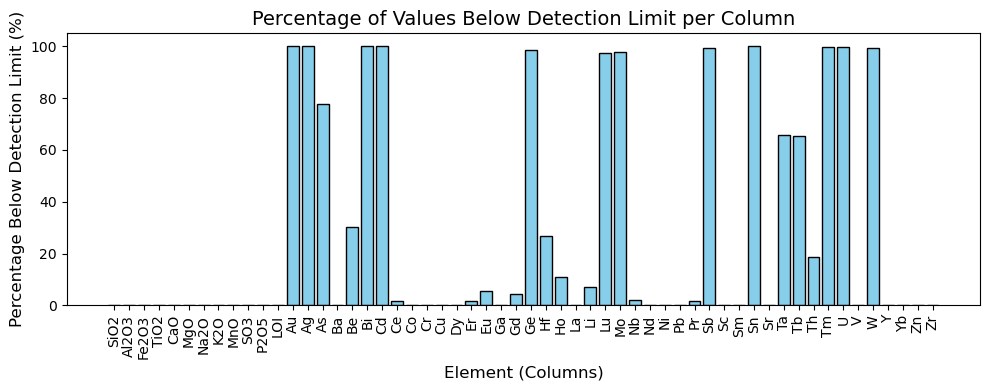

In [5]:
### Calculate + plot below detection limit percentage

# Assuming `gajhq_raw_data` and `gajhq_data` are loaded as in your code
dl_row1 = gajhq_raw_data.iloc[5]
dl_row2 = gajhq_raw_data.iloc[6]
below_dl_results = calculate_below_detection_percentage(gajhq_data, dl_row1, dl_row2)

# Print results
for column, percentage in below_dl_results.items():
    print(f"{column}: {percentage:.2f}% below DL")\
    

# Convert the results to two lists for plotting
columns = list(below_dl_results.keys())
percentages = list(below_dl_results.values())

# Plot the bar chart
plt.figure(figsize=(10, 4))
plt.bar(columns, percentages, color="skyblue", edgecolor="black")
plt.xlabel("Element (Columns)", fontsize=12)
plt.ylabel("Percentage Below Detection Limit (%)", fontsize=12)
plt.title("Percentage of Values Below Detection Limit per Column", fontsize=14)
plt.xticks(rotation=90, fontsize=10)  # Rotate column names for better readability
plt.tight_layout()  # Adjust layout to fit the x-axis labels
plt.show()

In [6]:
### Drop columns with n percentage below detection limit

# Calculate percentage below detection limit
below_dl_results = calculate_below_detection_percentage(
    gajhq_data, gajhq_raw_data.iloc[5], gajhq_raw_data.iloc[6]
)

# Drop columns exceeding the threshold percentage below DL

threshold_below_dl = 90

columns_to_drop = [
    col
    for col, percentage in below_dl_results.items()
    if percentage > threshold_below_dl
]
gajhq_data = gajhq_data.drop(columns=columns_to_drop)

# Print the columns that were dropped
print(f"Columns dropped due to exceeding {threshold_below_dl}% below DL:")
print(columns_to_drop)

# Ensure no columns with constant values remain
gajhq_data = gajhq_data.loc[:, gajhq_data.nunique() > 1]

Columns dropped due to exceeding 90% below DL:
['Au', 'Ag', 'Bi', 'Cd', 'Ge', 'Lu', 'Mo', 'Sb', 'Sn', 'Tm', 'U', 'W']


C:\Users\TyHow\AppData\Local\Temp\ipykernel_39848\1093865847.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dl_value = detection_limits[col_index]


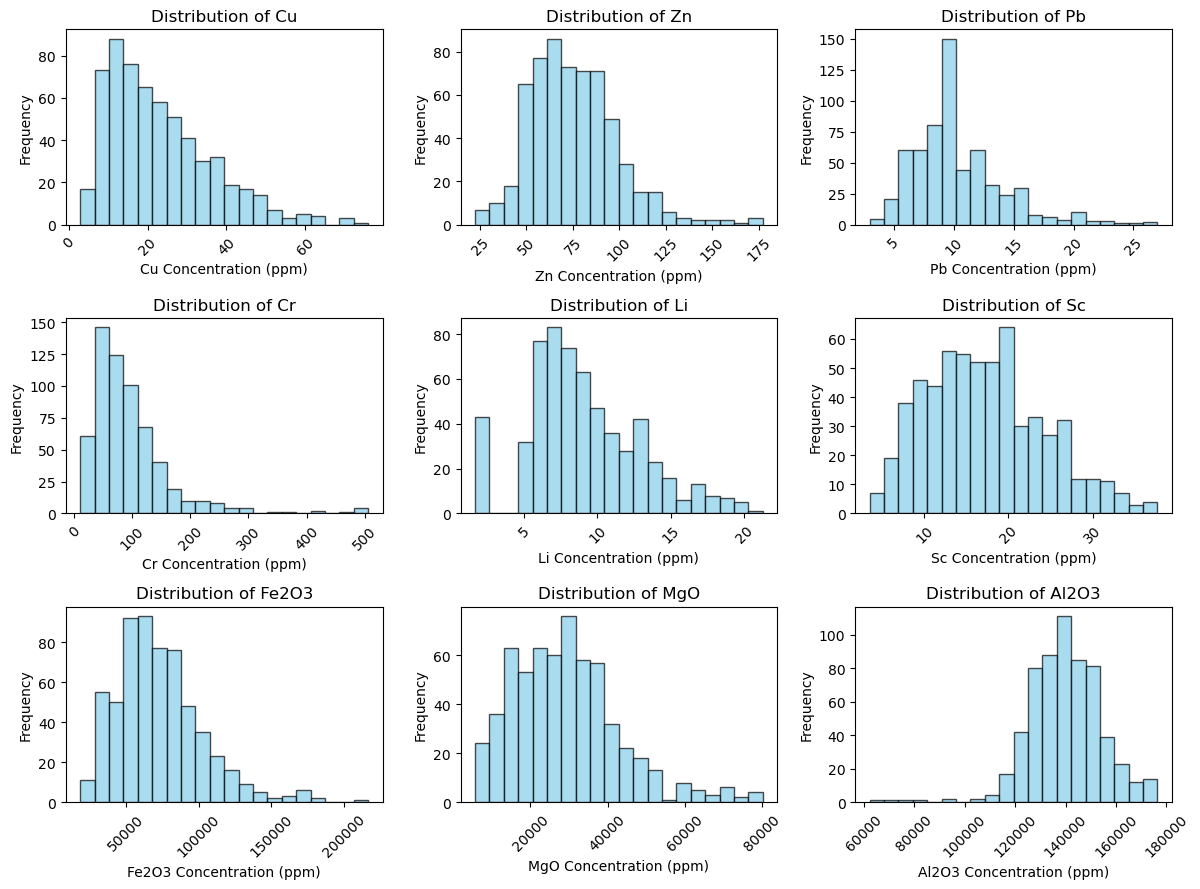

In [7]:

# Define the precious and base metals to plot
precious_base_metals = ["Cu", "Zn", "Pb", "Cr", "Li", 'Sc', 'Fe2O3', 'MgO', 'Al2O3']

# feO, mgO, other oxides, 

# Call the function with your data
plot_histograms(gajhq_data, precious_base_metals, bins=20, lower_cutoff=0, upper_cutoff=0.99)

Statistics:

Average correlation: 0.16078279442025534
Max correlation: 1.0
Min correlation: -0.809665348392544


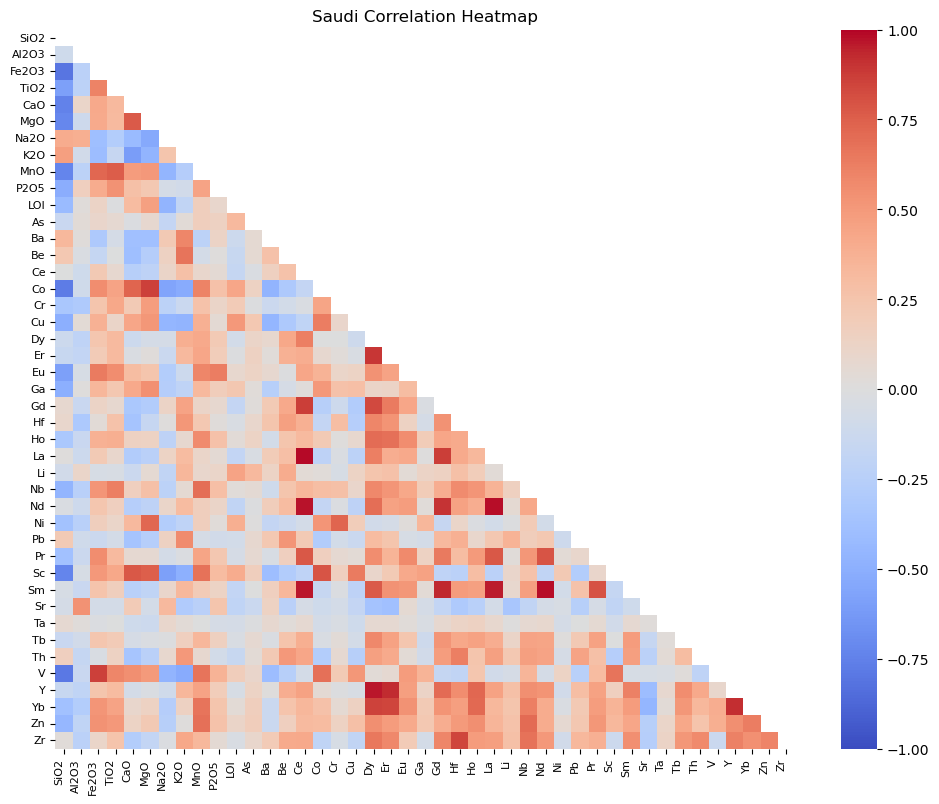

In [8]:
# Corr plot
gajhq_corr = gajhq_data.iloc[:, 3:].corr()

print("Statistics:\n")
print("Average correlation:", gajhq_corr.stack().mean())
print("Max correlation:", gajhq_corr.stack().max())
print("Min correlation:", gajhq_corr.stack().min())

# Create a mask for the upper triangle
gajhq_mask = np.triu(np.ones_like(gajhq_corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    gajhq_corr,
    mask=gajhq_mask,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
)

# Explicitly set tick positions and labels
tick_positions = np.arange(0.5, len(gajhq_corr))
plt.xticks(
    ticks=tick_positions,
    labels=gajhq_corr.columns,
    rotation=90,
    fontsize=8,
    ha="right",
)
plt.yticks(
    ticks=tick_positions,
    labels=gajhq_corr.index,
    rotation=0,
    fontsize=8,
)

plt.tight_layout()
plt.title("Saudi Correlation Heatmap")
plt.show()

In [9]:
### PCA

# Omit non-numeric columns
gajhq_data_pca = gajhq_data.copy()
gajhq_data_pca = gajhq_data_pca.iloc[:, 3:]

scaler = StandardScaler()
gajhq_data_scaled = scaler.fit_transform(gajhq_data_pca)

# Perform PCA
pca = PCA()
gajhq_pca_results = pca.fit_transform(gajhq_data_scaled)

# Explained variance
gajhq_explained_variance = pca.explained_variance_ratio_
#print("Explained Variance Ratios:", gajhq_explained_variance)

# PCA results as a DataFrame (optional)
pca_df = pd.DataFrame(
    gajhq_pca_results, columns=[f"PC{i+1}" for i in range(len(gajhq_explained_variance))]
)

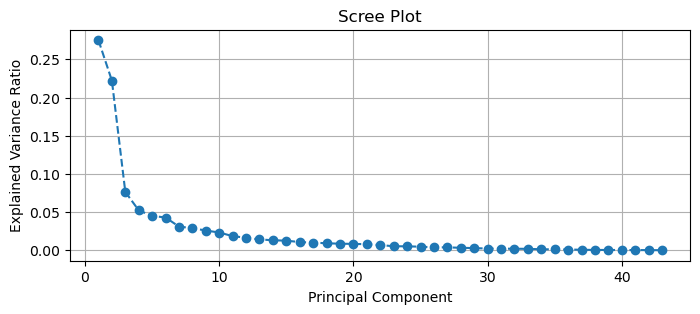

In [10]:
#Plot PCA scree plot
plt.figure(figsize=(8, 3))
plt.plot(
    range(1, len(gajhq_explained_variance) + 1),
    gajhq_explained_variance,
    marker="o",
    linestyle="--",
)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid()
plt.show()

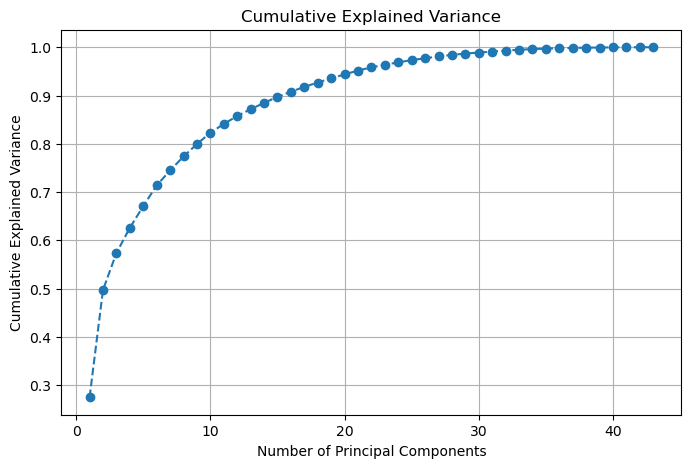

In [11]:
cumulative_variance = gajhq_explained_variance.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker="o",
    linestyle="--",
)
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

PC1: ['Dy', 'Y', 'Yb', 'Sm', 'Er']
PC1 Loadings:
  Yb: 0.1539
  Sm: 0.1521
  Dy: -0.1130
  Y: -0.0803
  Er: 0.0040

PC2: ['Co', 'Sc', 'MgO', 'CaO', 'SiO2']
PC2 Loadings:
  SiO2: 0.2658
  Co: -0.2658
  MgO: 0.1976
  CaO: 0.1464
  Sc: -0.0116

PC3: ['Sr', 'Li', 'Ce', 'Pr', 'La']
PC3 Loadings:
  Li: 0.1614
  Ce: 0.1477
  Sr: -0.0860
  La: 0.0769
  Pr: 0.0337

PC4: ['Ni', 'Cr', 'Al2O3', 'P2O5', 'MgO']
PC4 Loadings:
  Cr: -0.3058
  MgO: -0.0349
  Ni: 0.0322
  P2O5: -0.0087
  Al2O3: -0.0028



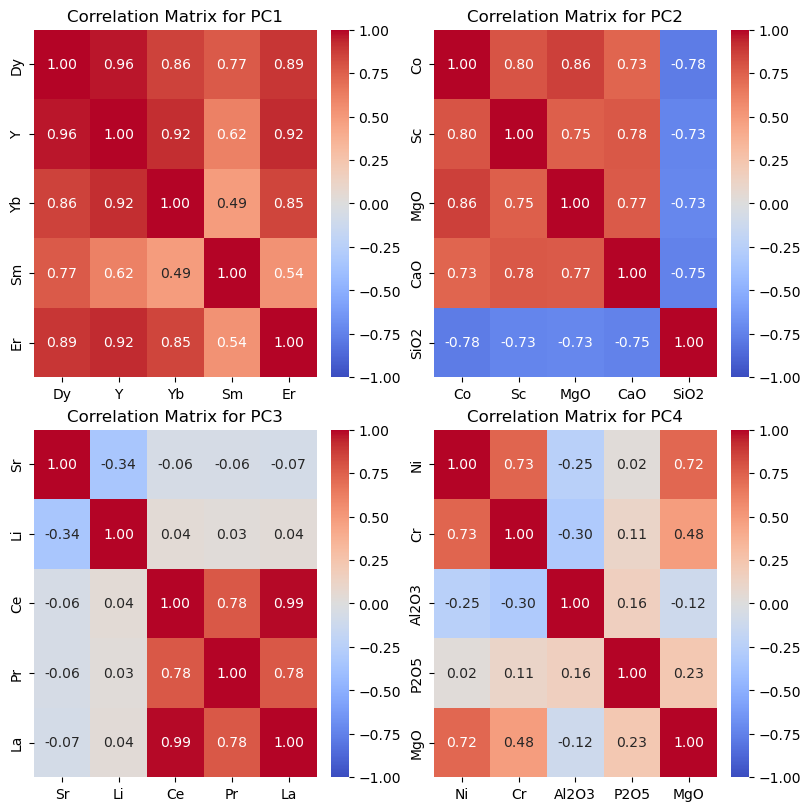

In [21]:
### Extract top features per PC

# Set parameters
num_pcs = 4  # Number of PCs to analyze
top_features_per_pc = 5  # Number of top features to extract per PC

# Prepare lists for groups of features
groups = {}

# Iterate through each PC and extract top features
for pc_index in range(num_pcs):
    # Extract feature contributions for the current PC
    contributions = pd.DataFrame(
        {
            "Feature": gajhq_data_pca.columns,
            f"PC{pc_index + 1} Contribution": np.abs(pca.components_[pc_index]),
        }
    )
    # Sort by contribution and select top features
    top_features = contributions.nlargest(
        top_features_per_pc, f"PC{pc_index + 1} Contribution"
    )["Feature"].tolist()
    groups[f"PC{pc_index + 1}"] = top_features

# Display groups of correlated features
for pc, features in groups.items():
    pc_index = int(pc.replace("PC", "")) - 1
    print(f"{pc}: {features}")

    # Pair the loadings with their feature names
    feature_loadings = list(zip(features, pca.components_[pc_index]))

    # Sort by absolute loading values (highest contribution)
    sorted_features = sorted(feature_loadings, key=lambda x: abs(x[1]), reverse=True)

    # Display the top 5 loadings
    print(f"{pc} Loadings:")
    for feature, loading in sorted_features[:5]:
        print(f"  {feature}: {loading:.4f}")
    print()


## Plot

# Number of PC groups
num_groups = len(groups)

# Calculate rows and columns for square-like layout
cols = math.ceil(math.sqrt(num_groups))
rows = math.ceil(num_groups / cols)

# Create a grid of subplots
fig, axes = plt.subplots(
    rows, cols, figsize=(cols * 4, rows * 4), constrained_layout=True
)

# Flatten the axes array for easy iteration (handles cases where rows > 1)
axes = axes.flatten()

# Iterate through the groups and plot each correlation matrix on a subplot
for idx, (pc, features) in enumerate(groups.items()):
    corr_matrix = gajhq_data_pca[features].corr()
    sns.heatmap(
        corr_matrix,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        vmin=-1,
        vmax=1,
        ax=axes[idx],
    )
    axes[idx].set_title(f"Correlation Matrix for {pc}")

# Hide any unused subplots
for ax in axes[num_groups:]:
    ax.axis("off")

# Show the final plot with all subplots
plt.show()

#### *Findings from PCA corr plots*

- <u>PC1:</u>
    - Dy/Y/Yb/Sm/Er REEs
    - Yb/Er/Dy/Sm HREEs
    - Yb/Sm/Er positive loadings, Dy/Y negative (possible decoupling of elements due to fractionation/mineral control)
    - *Represents REE-enrichment: high values = more REEs*

- <u>PC2:</u>
    - Co, Sc, MgO, CaO all mafic, SiO2 felsic
    - SiO2/MgO/CaO positive loadings, Co/Sc negative
    - *Represents mafic-felsic composition: high values = more  felsic???*

- <u>PC3:</u>
    - Ce/La/Pr LREEs, Li alongisde them, Sr depleted in highly fractionated systems
    - LREEs often associated with pegmatites
    - Li/Ce/La/Pr positive loadings, Sr negative
    - *Represents LREE/Li enrichment, pegmatitic systems: high value = more LREEs/Li/pegmatitc*

- <u>PC4:</u>
    - Pretty garbled... 
    - *MAY represent polymetallic sulfide systems,  high value = polymetallic, low value = ultramafic intrusion?*

<br />
<br />
Broadly, PC1 represents REE enrichment, dominated by HREEs. PC2 represents mafic-felsic differentiation. PC3 represents LREE and Li enrichment. PC4 MAY represent polymetallic sulfides vs. ultramafic systems. 
<br />
<br />

***

c:\Users\TyHow\anaconda3\envs\conda_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


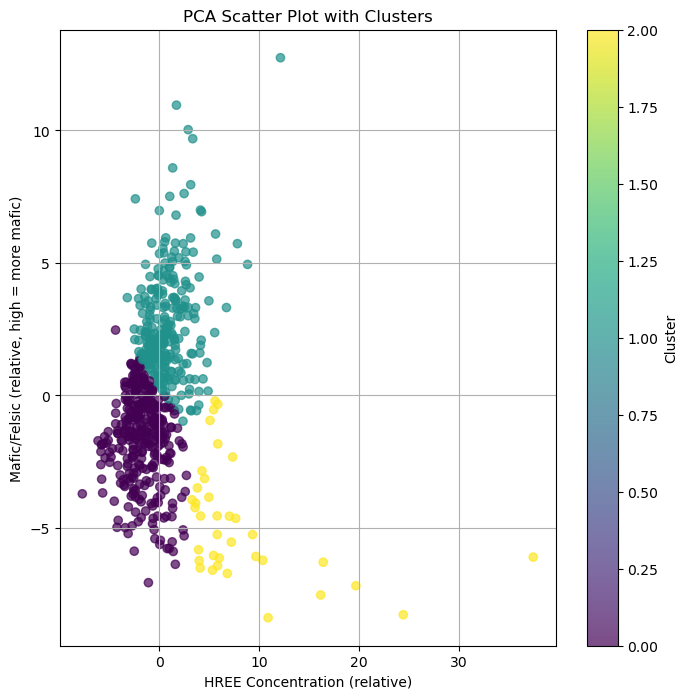

In [13]:
# Perform clustering on the PCA results (e.g., using the first 2 PCs)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_df[["PC1", "PC2"]])

# Add cluster labels to the PCA DataFrame
pca_df["Cluster"] = clusters

# Visualize clusters on the PCA scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(
    pca_df["PC1"], pca_df["PC2"], c=pca_df["Cluster"], cmap="viridis", alpha=0.7
)
plt.title("PCA Scatter Plot with Clusters")
plt.xlabel("HREE Concentration (relative)")
plt.ylabel("Mafic/Felsic (relative, high = more mafic)")
plt.colorbar(label="Cluster")
plt.grid()
plt.show()

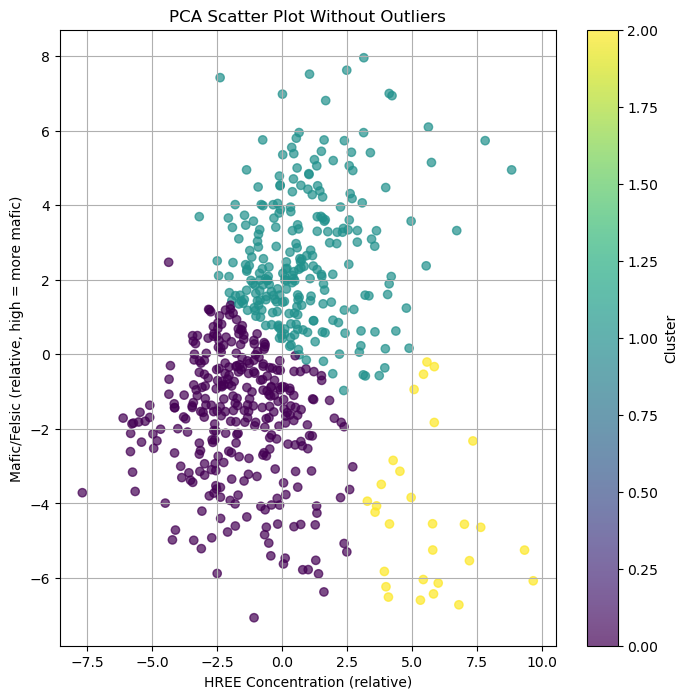

In [14]:
# Define thresholds for PC1 (HREE concentration) and PC2 (mafic/felsic)
pc1_threshold = 10  # Keep samples with PC1 < 10
pc2_threshold = 8  # Keep samples with PC2 < 8

# Filter out outliers
filtered_data = pca_df[
    (pca_df["PC1"] < pc1_threshold) & (pca_df["PC2"] < pc2_threshold)
]

# Replot without outliers
plt.figure(figsize=(8, 8))
plt.scatter(
    filtered_data["PC1"],
    filtered_data["PC2"],
    c=filtered_data["Cluster"],
    cmap="viridis",
    alpha=0.7,
)
plt.colorbar(label="Cluster")
plt.title("PCA Scatter Plot Without Outliers")
plt.xlabel("HREE Concentration (relative)")
plt.ylabel("Mafic/Felsic (relative, high = more mafic)")
plt.grid()
plt.show()

c:\Users\TyHow\anaconda3\envs\conda_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\TyHow\anaconda3\envs\conda_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\TyHow\anaconda3\envs\conda_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\TyHow\anaconda3\envs\conda_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: 

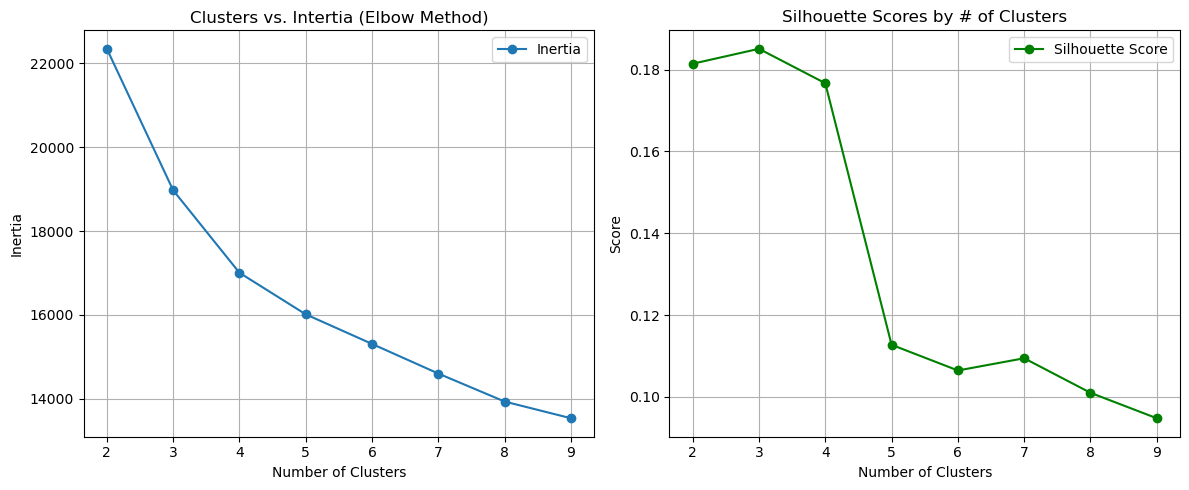

In [15]:
# Step 1: Preprocessing - Select numeric geochemical data and standardize
gajhq_data_numeric = gajhq_data.iloc[:, 3:].copy()  # Exclude non-numeric columns
gajhq_data_numeric = gajhq_data_numeric.apply(
    pd.to_numeric, errors="coerce"
)  # Convert to numeric
scaler = StandardScaler()
gajhq_data_scaled2 = scaler.fit_transform(gajhq_data_numeric)

# Step 2: Determine optimal number of clusters using the Elbow Method
inertia = []
silhouette = []

for k in range(2, 10):  # Test different numbers of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(gajhq_data_scaled2)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(gajhq_data_scaled2, kmeans.labels_))

# Plot Inertia (Elbow) and Silhouette Scores
plt.figure(figsize=(12, 5))

# Inertia (Elbow)
plt.subplot(1, 2, 1)
plt.plot(range(2, 10), inertia, marker="o", label="Inertia")
plt.title("Clusters vs. Intertia (Elbow Method)")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid()
plt.legend()

# Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 10), silhouette, marker="o", label="Silhouette Score", color="green")
plt.title("Silhouette Scores by # of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
# Step 3: Perform K-means clustering with optimal number of clusters (e.g., k=3)
gajhq_optimal_k = 3  # Based on the elbow plot
gajhq_kmeans = KMeans(n_clusters=gajhq_optimal_k, random_state=42)
gajhq_clusters = gajhq_kmeans.fit_predict(gajhq_data_scaled2)

# Step 4: Convert scaled data back to a DataFrame
gajhq_data_scaled_df = pd.DataFrame(
    gajhq_data_scaled2, columns=gajhq_data_numeric.columns
)  # Use original column names
gajhq_data_scaled_df["Cluster"] = gajhq_clusters  # Add cluster assignments

# Step 5: Analyze clustering results
print('Clustering Complete\n.............\n')
print(
    gajhq_data_scaled_df.groupby("Cluster").mean()
)  # Compare mean geochemical values for each cluster

Clustering Complete
.............

             SiO2     Al2O3     Fe2O3      TiO2       CaO       MgO      Na2O  \
Cluster                                                                         
0        0.635826  0.084096 -0.547981 -0.377035 -0.468045 -0.518321  0.417597   
1       -0.830579 -0.022128  0.646364  0.441713  0.716625  0.739065 -0.550555   
2        0.544685 -0.672216  0.119881  0.108050 -1.293610 -0.969875  0.400572   

              K2O       MnO      P2O5  ...        Sm        Sr        Ta  \
Cluster                                ...                                 
0        0.256426 -0.606546 -0.309360  ... -0.182200  0.227021  0.023468   
1       -0.512573  0.681734  0.433997  ... -0.113028 -0.159971 -0.054810   
2        1.726438  0.418679 -0.518511  ...  2.822057 -0.964301  0.225018   

               Tb        Th         V         Y        Yb        Zn        Zr  
Cluster                                                                        
0       -0.205470 

c:\Users\TyHow\anaconda3\envs\conda_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


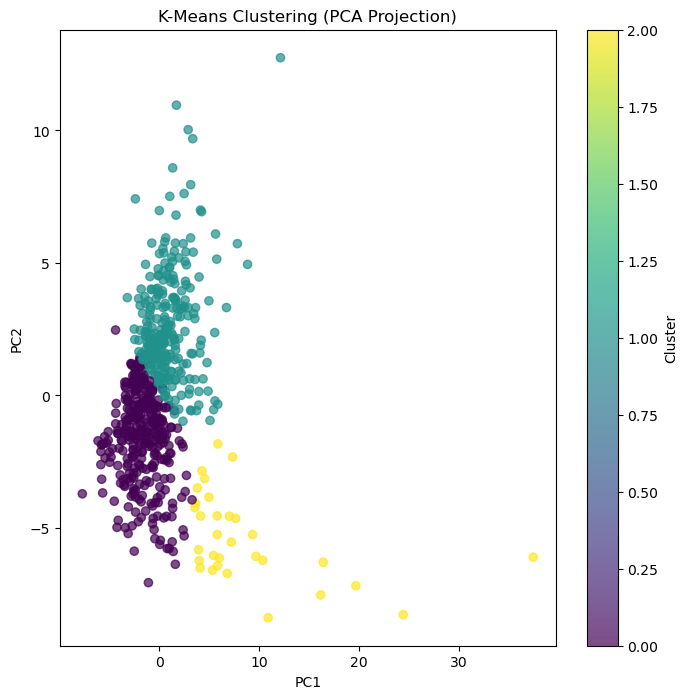

In [17]:
# Reduce dimensions with PCA for visualization
pca2 = PCA(n_components=3)
gajhq_data_pca2 = pca2.fit_transform(gajhq_data_scaled2)

# Plot clusters
PC1 = 0
PC2 = 1

plt.figure(figsize=(8, 8))
plt.scatter(gajhq_data_pca2[:, PC1], gajhq_data_pca2[:, PC2], c=gajhq_clusters, cmap="viridis", alpha=0.7)
plt.title("K-Means Clustering (PCA Projection)")
plt.xlabel(f"PC{PC1+1}")
plt.ylabel(f"PC{PC2+1}")
plt.colorbar(label="Cluster")
plt.show()

In [18]:
### Spatial Investigation

gajhq_data_spatial = gajhq_data.iloc[:, 1:].copy()  
gajhq_data_spatial = gajhq_data_spatial.apply(
    pd.to_numeric, errors="coerce"
)  # Convert to numeric

# Convert the DataFrame to a GeoDataFrame
gajhq_data_spatial["geometry"] = gajhq_data_spatial.apply(
    lambda row: Point(row["LONG"], row["LAT"]), axis=1
)
gajhq_geo_data = gpd.GeoDataFrame(
    gajhq_data_spatial, geometry="geometry", crs="EPSG:4326"
)  # WGS84 CRS
gajhq_geo_data["Cluster"] = gajhq_clusters

# Inspect the GeoDataFrame
#print(gajhq_geo_data.head())
#print(gajhq_geo_data["Cluster"].unique())

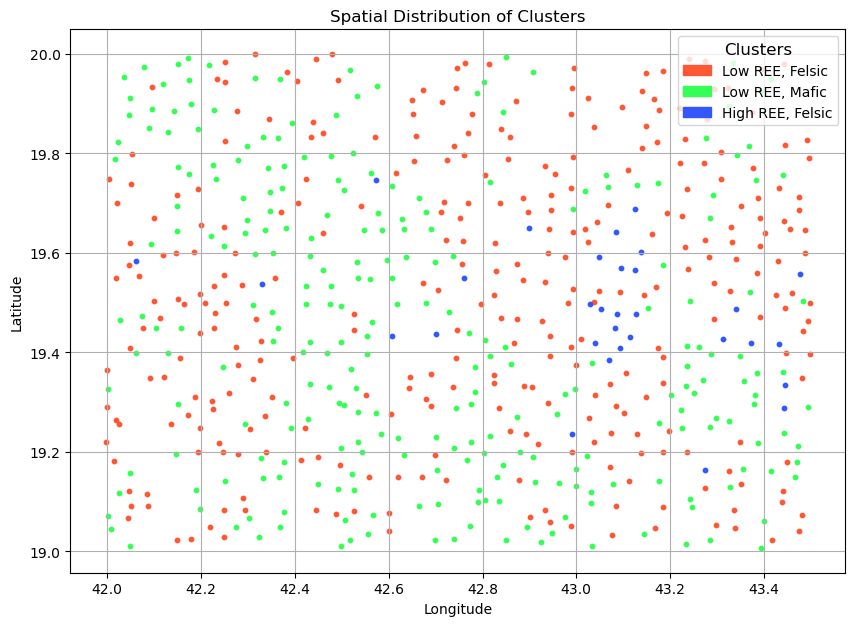

In [19]:
### Spatial Analysis

# Custom cluster colors (ensure consistency with the plot)
cluster_colors = {
    0: "#FF5733",
    1: "#33FF57",
    2: "#3357FF",
}  # Vibrant colors for clusters

# Add a 'Color' column to GeoDataFrame
gajhq_geo_data["Color"] = gajhq_geo_data["Cluster"].map(cluster_colors)

# Define new names for the clusters
cluster_names = {0: "Low REE, Felsic", 1: "Low REE, Mafic", 2: "High REE, Felsic"}

# Add a new column to the GeoDataFrame with descriptive cluster names
gajhq_geo_data["Cluster_Name"] = gajhq_geo_data["Cluster"].map(cluster_names)

# Plot the clusters
fig, ax = plt.subplots(figsize=(10, 8))
for cluster, color in cluster_colors.items():
    subset = gajhq_geo_data[gajhq_geo_data["Cluster"] == cluster]
    subset.plot(color=color, markersize=10, ax=ax, label=f"Cluster {cluster}")

# Add a categorical legend (aligned with cluster colors)
handles = [
    mpatches.Patch(color=color, label=cluster_names[cluster])
    for cluster, color in cluster_colors.items()
]
plt.legend(
    handles=handles, title="Clusters", loc="upper right", fontsize=10, title_fontsize=12
)

# Add titles and labels
plt.title("Spatial Distribution of Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.show()

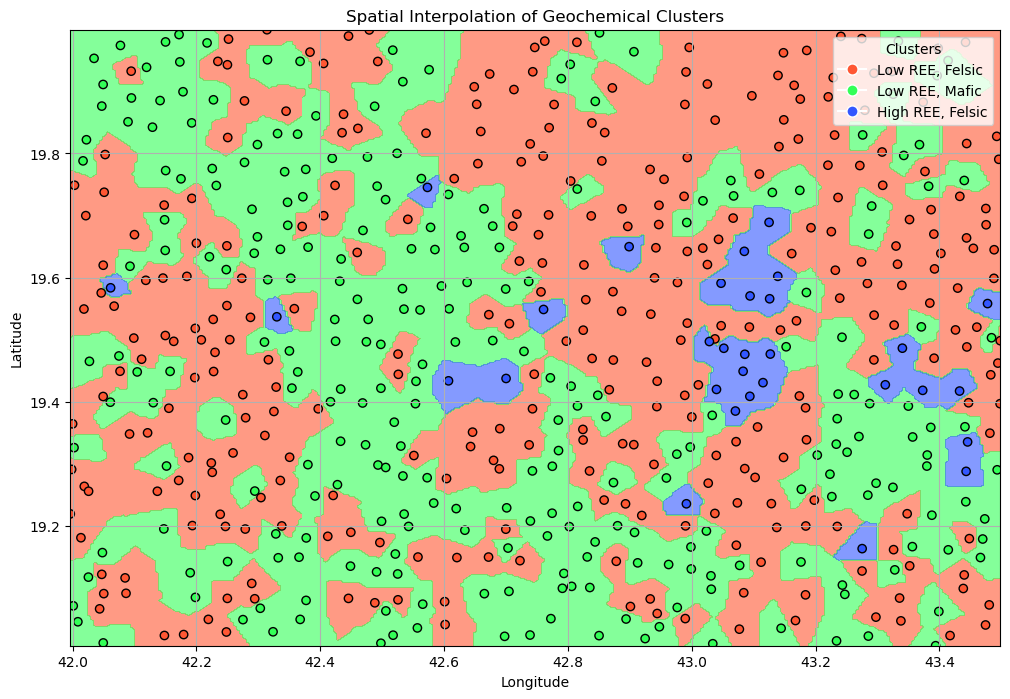

In [20]:
# Extract spatial coordinates and cluster labels
x = gajhq_geo_data["LONG"].values
y = gajhq_geo_data["LAT"].values
z = gajhq_geo_data["Cluster"].values  # Cluster labels

# Define the grid for interpolation
xi, yi = np.meshgrid(
    np.linspace(x.min(), x.max(), 300),  # Adjust resolution
    np.linspace(y.min(), y.max(), 300),
)

# Perform nearest neighbor interpolation
zi = griddata((x, y), z, (xi, yi), method="nearest")

# Use your custom colors for the clusters
custom_cmap = ListedColormap([cluster_colors[i] for i in sorted(cluster_colors.keys())])

# Plot the interpolated clusters
plt.figure(figsize=(12, 8))
plt.contourf(
    xi,
    yi,
    zi,
    levels=np.arange(len(cluster_colors) + 1) - 0.5,
    cmap=custom_cmap,
    alpha=0.6,
)
#plt.colorbar(ticks=range(len(cluster_colors)), label="Cluster")  # Add a colorbar
plt.scatter(
    x, y, c=z, cmap=custom_cmap, edgecolor="k", label="Sample Points"
)  # Overlay sample points
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Interpolation of Geochemical Clusters")
plt.legend(
    handles=[
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=cluster_names[cluster],
            markersize=8,
            markerfacecolor=color,
        )
        for cluster, color in cluster_colors.items()
    ],
    title="Clusters",
    loc="upper right",
)
plt.grid()
plt.show()